In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


class State:
    def __init__(self, BOARD_ROWS, BOARD_COLS, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.BOARD_ROWS = BOARD_ROWS
        self.BOARD_COLS = BOARD_COLS
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(self.BOARD_COLS * self.BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # row
        for i in range(self.BOARD_ROWS):
            if sum(self.board[i, :]) == self.BOARD_ROWS:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -self.BOARD_ROWS:
                self.isEnd = True
                return -1
        # col
        for i in range(self.BOARD_COLS):
            if sum(self.board[:, i]) == self.BOARD_ROWS:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -self.BOARD_ROWS:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(self.BOARD_COLS)])
        diag_sum2 = sum([self.board[i, self.BOARD_COLS - i - 1] for i in range(self.BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == self.BOARD_ROWS:
            self.isEnd = True
            if diag_sum1 == self.BOARD_ROWS or diag_sum2 == self.BOARD_ROWS:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(self.BOARD_ROWS):
            for j in range(self.BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    # board reset
    def reset(self):
        self.board = np.zeros((self.BOARD_ROWS, self.BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds):
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    def playgame(self, rounds=10000):
        for i in range(rounds):
            if i % 10000 == 0:
                print("Rounds {}".format(i))
            self.reset()
            self.p1.reset()
            self.p2.reset()
            
            while not self.isEnd:
                # Player 1's turn
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                p1_state_hash = self.getHash()
                self.updateState(p1_action)

                # Check for win
                win = self.winner()
                if win is not None:
                    # Update for game end
                    if win == 1:
                        self.p1.feedReward(p1_state_hash, p1_action, 1, None, None)
                        self.p2.feedReward(None, None, -1, None, None)
                    else:
                        self.p1.feedReward(p1_state_hash, p1_action, 0.5, None, None)
                        self.p2.feedReward(None, None, 0.5, None, None)
                    break

                # Player 2's turn
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                p2_state_hash = self.getHash()
                self.updateState(p2_action)
                win = self.winner()
                if win is not None:
                    if win == -1:
                        self.p2.feedReward(p2_state_hash, p2_action, 1, None, None)
                        self.p1.feedReward(p1_state_hash, p1_action, -1, None, None)
                    else:
                        self.p2.feedReward(p2_state_hash, p2_action, 0.5, None, None)
                        self.p1.feedReward(p1_state_hash, p1_action, 0.5, None, None)
                    break
                # Update the Q-value using SARSA for player 1
                positions_1 = self.availablePositions()
                p1_next_action = self.p1.chooseAction(positions_1, self.board, self.playerSymbol)
                self.p1.feedReward(p1_state_hash, p1_action, 0, self.getHash(), p1_next_action)

                # Check for win
                win = self.winner()
                if win is not None:
                    if win == -1:
                        self.p2.feedReward(p2_state_hash, p2_action, 1, None, None)
                        self.p1.feedReward(p1_state_hash, p1_action, -1, None, None)
                    else:
                        self.p2.feedReward(p2_state_hash, p2_action, 0.5, None, None)
                        self.p1.feedReward(p1_state_hash, p1_action, 0.5, None, None)
                    break
                    
    def evaluate(self):
        while not self.isEnd:
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            p1_state_hash = self.getHash()  
            self.updateState(p1_action)
    
            win = self.winner()
            if win is not None:
                self.p1.feedReward(p1_state_hash, p1_action, 1 if win == 1 else 0, None, None)
                self.p1.reset()
                self.p2.reset()
                self.reset()
                return win
    
            positions = self.availablePositions()
            p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
            p2_state_hash = self.getHash()  # Save state before the action
            self.updateState(p2_action)
    
            win = self.winner()
            if win is not None:
                self.p1.feedReward(p1_state_hash, p1_action, -1 if win == -1 else 0, None, None)
                self.p1.reset()
                self.p2.reset()
                self.reset()
                return win



    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, self.BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, self.BOARD_COLS):
                token = ""
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')



class PlayerSARSA:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.lr = 0.2  
        self.exp_rate = exp_rate  
        self.decay_gamma = 0.9  
        self.states_value = {}  

    def chooseAction(self, positions, current_board, symbol):

        if np.random.uniform(0, 1) <= self.exp_rate and len(positions) > 0:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            action = positions[0]
            for p in positions:
                next_board = current_board.copy()
                next_board[p[0], p[1]] = symbol
                next_board_hash = str(next_board.reshape(-1))
                value = 0 if self.states_value.get(next_board_hash) is None else self.states_value.get(next_board_hash)
                if value > value_max:
                    value_max = value
                    action = p
        return action

    def feedReward(self, state, action, reward, next_state, next_action):

        state_action = (state, action)
        next_state_action = (next_state, next_action)

        if self.states_value.get(state_action) is None:
            self.states_value[state_action] = 0

        if self.states_value.get(next_state_action) is None:
            self.states_value[next_state_action] = 0

        self.states_value[state_action] += self.lr * (
            reward + self.decay_gamma * self.states_value[next_state_action] - self.states_value[state_action]
        )

    def reset(self):
        self.states_value = {}

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()


In [2]:
# training
board_size = 4
p1 = PlayerSARSA("p1")
p2 = PlayerSARSA("p2")

st = State(board_size, board_size, p1, p2)
print("training...")
st.playgame(100000)

p1.savePolicy()
p2.savePolicy()

training...
Rounds 0
Rounds 10000
Rounds 20000
Rounds 30000
Rounds 40000
Rounds 50000
Rounds 60000
Rounds 70000
Rounds 80000
Rounds 90000


In [3]:
check_p1 = PlayerSARSA("computer_1")
check_p1.loadPolicy("policy_p1")
check_p2 = PlayerSARSA("computer_2")
check_p2.loadPolicy("policy_p2")
st = State(board_size, board_size, p1, p2)

In [4]:
win_percentage = 0
draw_percentage = 0 
lose_percentage = 0
for i in range(100):
    result = st.evaluate()
    if result == 1:
        win_percentage += 1
    elif result == -1:
        lose_percentage += 1
    else:
        draw_percentage += 1

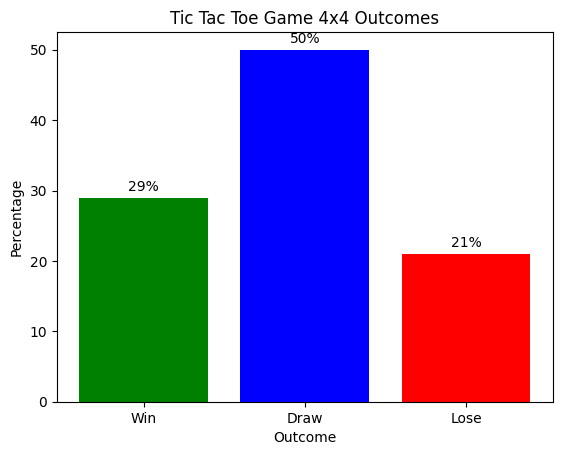

In [5]:
labels = ['Win', 'Draw', 'Lose']

percentages = [win_percentage, draw_percentage, lose_percentage]

fig, ax = plt.subplots()
bars = ax.bar(labels, percentages, color=['green', 'blue', 'red'])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  
                textcoords="offset points", 
                ha='center', va='bottom')

plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title(f"Tic Tac Toe Game {board_size}x{board_size} Outcomes")

plt.show()